In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper librarie
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import urllib3
import matplotlib.pyplot as plt

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_info.features["label"].num_classes

2

In [9]:
ds_info.features["label"].names

['cat', 'dog']

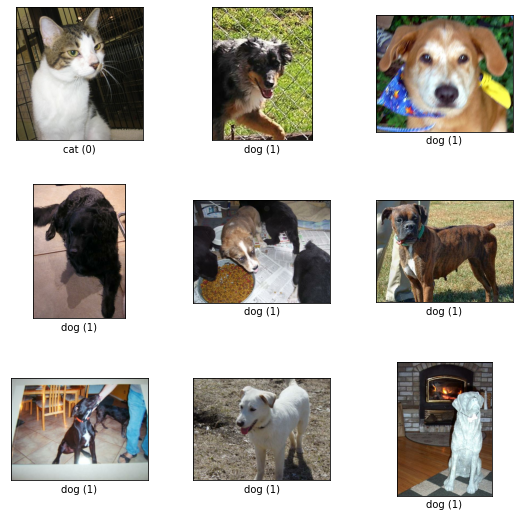

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

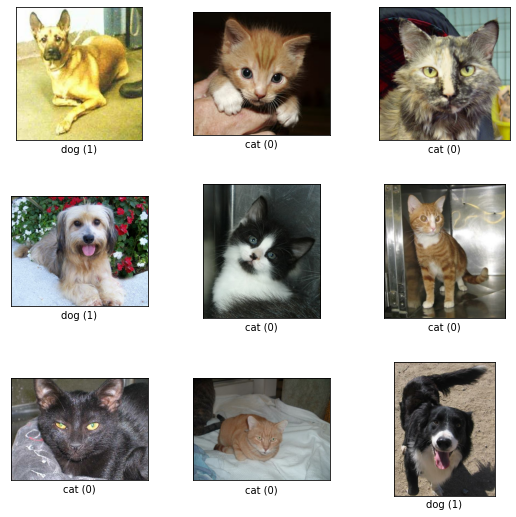

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

In [12]:
def cnn_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                    is_50=False,
                    residual_on=True
                   ):
    # 입력 레이어
    x = input_layer
            
    # CNN 레이어    
    if not is_50:
        for i in range(num_cnn):
            residual = x
            strides=(1,1)
        
            if (block_num!=0) & (i==0):
                residual = tf.keras.layers.Conv2D(filters=channel,kernel_size=(1,1),strides=(2,2))(x)
                residual = tf.keras.layers.BatchNormalization()(residual)
                
            if (block_num>0) & (i==0):
                strides=(2,2)

            x = tf.keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    strides=strides,
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'{block_num+1}_{i+1}_conv1'
                )(x)
            x = tf.keras.layers.BatchNormalization(name=f'{block_num+1}_{i+1}_bn1')(x)
            x = tf.keras.layers.ReLU(name=f'{block_num+1}_{i+1}_relu1')(x)
            
            strides=(1,1)
            x = tf.keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    strides=strides,
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'{block_num+1}_{i+1}_conv2'
                )(x)
            x = tf.keras.layers.BatchNormalization(name=f'{block_num+1}_{i+1}_bn2')(x)
            
            if residual_on:
                x = tf.keras.layers.Add(name=f'{block_num+1}_{i+1}_add')([x,residual])
            
            x = tf.keras.layers.ReLU(name=f'{block_num+1}_{i+1}_relu2')(x)

    if is_50:  
        for i in range(num_cnn):
            residual = x
            strides=(1,1)
            if (block_num==0) & (i==0):
                residual = tf.keras.layers.Conv2D(filters=channel*4,kernel_size=(1,1),strides=(1,1))(x)
                residual = tf.keras.layers.BatchNormalization()(residual)
                #residual = tf.concat([residual,residual*tf.constant(0,dtype=tf.float32)],axis=-1)
                #residual = tf.concat([residual,residual*tf.constant(0,dtype=tf.float32)],axis=-1)
        
            if (block_num!=0) & (i==0):
                residual = tf.keras.layers.Conv2D(filters=channel*4,kernel_size=(1,1),strides=(2,2))(x)
                residual = tf.keras.layers.BatchNormalization()(residual)
                #residual = tf.concat([residual,residual*tf.constant(0,dtype=tf.float32)],axis=-1)
                #residual = tf.concat([residual,residual*tf.constant(0,dtype=tf.float32)],axis=-1)
            
            if (block_num>0) & (i==0):
                strides=(2,2)

            x = tf.keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    strides=strides,
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'{block_num+1}_{i+1}_conv1'
                )(x)
            x = tf.keras.layers.BatchNormalization(name=f'{block_num+1}_{i+1}_bn1')(x)
            x = tf.keras.layers.ReLU(name=f'{block_num+1}_{i+1}_relu1')(x) 
            
            strides=(1,1)
            x = tf.keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    strides=strides,
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'{block_num+1}_{i+1}_conv2'
                )(x)
            x = tf.keras.layers.BatchNormalization(name=f'{block_num+1}_{i+1}_bn2')(x)
            x = tf.keras.layers.ReLU(name=f'{block_num+1}_{i+1}_relu2')(x)
            
            x = tf.keras.layers.Conv2D(
                    filters=channel*4,
                    kernel_size=(1,1),
                    strides=strides,
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'{block_num+1}_{i+1}_conv3'
                )(x)
            x = tf.keras.layers.BatchNormalization(name=f'{block_num+1}_{i+1}_bn3')(x)

            if residual_on:
                x = tf.keras.layers.Add(name=f'{block_num+1}_{i+1}_add')([x,residual])
            
            x = tf.keras.layers.ReLU(name=f'{block_num+1}_{i+1}_relu3')(x)

    return x

In [13]:
def build_resnet(input_shape=(224,224,3), num_classes=1, is_50=False, residual_on=True):
    num_cnn_list=[3,4,6,3]
    channel_list=[64,128,256,512]
    num_classes=num_classes
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = tf.keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    output = tf.keras.layers.Conv2D(filters=64,kernel_size=(7,7),strides=(2,2),padding='same',name='conv0')(output)
    output = tf.keras.layers.BatchNormalization(name='bn0')(output)
    output = tf.keras.layers.ReLU(name='relu0')(output)
    output = tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2),padding='same',name='maxpool')(output)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = cnn_block(
            output,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i,
            is_50=is_50,
            residual_on=residual_on
        )
        
    output = tf.keras.layers.GlobalAveragePooling2D(name='averagepool')(output)
    output = tf.keras.layers.Flatten(name='flatten')(output)
    output = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [14]:
resnet_34 = build_resnet(input_shape=(32, 32,3), num_classes=10, is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 16, 16, 64)   256         conv0[0][0]                      
__________________________________________________________________________________________________
relu0 (ReLU)                    (None, 16, 16, 64)   0           bn0[0][0]                        
______________________________________________________________________________________________

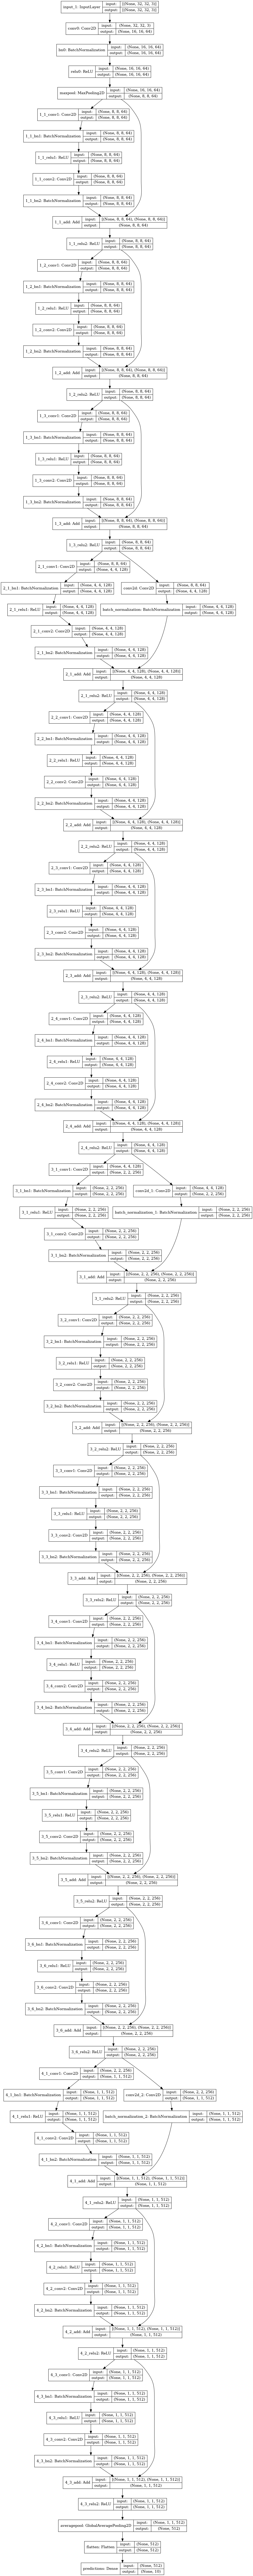

In [15]:
tf.keras.utils.plot_model(resnet_34, to_file='./resnet_34.png', show_shapes=True)

In [16]:
resnet_50 = build_resnet(input_shape=(32, 32,3), num_classes=10, is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 16, 16, 64)   256         conv0[0][0]                      
__________________________________________________________________________________________________
relu0 (ReLU)                    (None, 16, 16, 64)   0           bn0[0][0]                        
____________________________________________________________________________________________

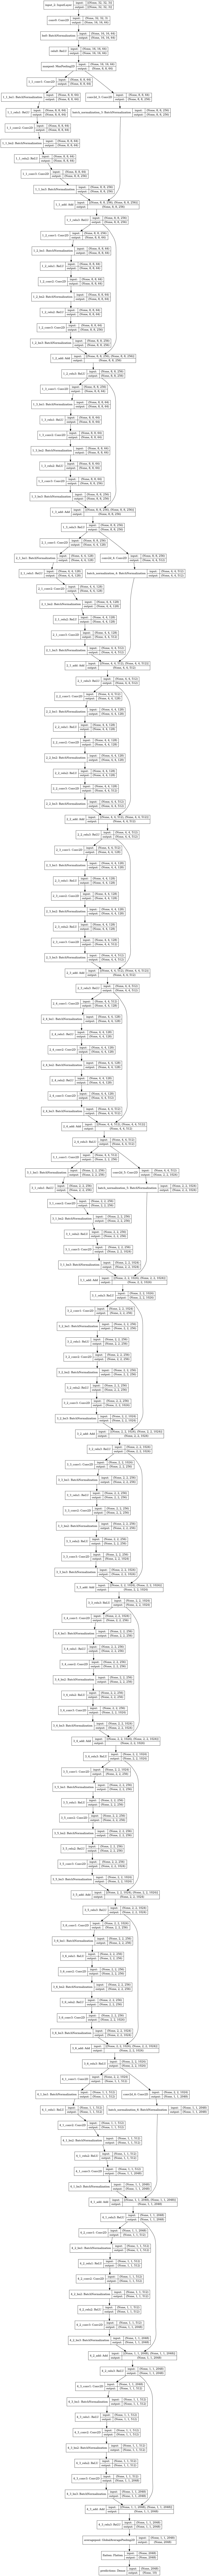

In [17]:
tf.keras.utils.plot_model(resnet_50, to_file='./resnet_50.png', show_shapes=True)

In [18]:
BATCH_SIZE = 64
EPOCH = 20

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [20]:
resnet_34 = build_resnet(is_50=False)
resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 112, 112, 64) 256         conv0[0][0]                      
__________________________________________________________________________________________________
relu0 (ReLU)                    (None, 112, 112, 64) 0           bn0[0][0]                        
____________________________________________________________________________________________

In [21]:
resnet_50 = build_resnet(is_50=True)
resnet_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 112, 112, 64) 256         conv0[0][0]                      
__________________________________________________________________________________________________
relu0 (ReLU)                    (None, 112, 112, 64) 0           bn0[0][0]                        
____________________________________________________________________________________________

In [22]:
def build_plainnet(is_50=False):
    return build_resnet(is_50=is_50,residual_on=False)

In [23]:
plainnet_34 = build_plainnet()
plainnet_34.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv0 (Conv2D)               (None, 112, 112, 64)      9472      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 112, 112, 64)      256       
_________________________________________________________________
relu0 (ReLU)                 (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool (MaxPooling2D)       (None, 56, 56, 64)        0         
_________________________________________________________________
1_1_conv1 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
1_1_bn1 (BatchNormalization) (None, 56, 56, 64)        256 

In [24]:
plainnet_50 = build_plainnet(is_50=True)
plainnet_50.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv0 (Conv2D)               (None, 112, 112, 64)      9472      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 112, 112, 64)      256       
_________________________________________________________________
relu0 (ReLU)                 (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool (MaxPooling2D)       (None, 56, 56, 64)        0         
_________________________________________________________________
1_1_conv1 (Conv2D)           (None, 56, 56, 64)        4160      
_________________________________________________________________
1_1_bn1 (BatchNormalization) (None, 56, 56, 64)        256 

In [25]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    #optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
290/290 [==============================] - 285s 842ms/step - loss: 0.6861 - accuracy: 0.5886 - val_loss: 0.7634 - val_accuracy: 0.4850
Epoch 2/20
290/290 [==============================] - 251s 865ms/step - loss: 0.6119 - accuracy: 0.6607 - val_loss: 0.6470 - val_accuracy: 0.6286
Epoch 3/20
290/290 [==============================] - 232s 800ms/step - loss: 0.5922 - accuracy: 0.6811 - val_loss: 0.7178 - val_accuracy: 0.6042
Epoch 4/20
290/290 [==============================] - 232s 799ms/step - loss: 0.5410 - accuracy: 0.7220 - val_loss: 0.8283 - val_accuracy: 0.5902
Epoch 5/20
290/290 [==============================] - 232s 799ms/step - loss: 0.4960 - accuracy: 0.7580 - val_loss: 0.8217 - val_accuracy: 0.5985
Epoch 6/20
290/290 [==============================] - 232s 800ms/step - loss: 0.4542 - accuracy: 0.7863 - val_loss: 0.7531 - val_accuracy: 0.6613
Epoch 7/20
290/290 [==============================] - 232s 799ms/step - loss: 0.4088 - accuracy: 0.8134 - val_loss: 1.2130 -

In [26]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    #optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
290/290 [==============================] - 480s 1s/step - loss: 0.6903 - accuracy: 0.5649 - val_loss: 0.7071 - val_accuracy: 0.4848
Epoch 2/20
290/290 [==============================] - 469s 2s/step - loss: 0.6641 - accuracy: 0.5994 - val_loss: 0.7247 - val_accuracy: 0.5455
Epoch 3/20
290/290 [==============================] - 423s 1s/step - loss: 0.6449 - accuracy: 0.6314 - val_loss: 0.7851 - val_accuracy: 0.5543
Epoch 4/20
290/290 [==============================] - 423s 1s/step - loss: 0.6408 - accuracy: 0.6365 - val_loss: 0.7510 - val_accuracy: 0.5723
Epoch 5/20
290/290 [==============================] - 424s 1s/step - loss: 0.6297 - accuracy: 0.6504 - val_loss: 0.6742 - val_accuracy: 0.5879
Epoch 6/20
290/290 [==============================] - 423s 1s/step - loss: 0.6303 - accuracy: 0.6374 - val_loss: 0.6856 - val_accuracy: 0.6033
Epoch 7/20
290/290 [==============================] - 423s 1s/step - loss: 0.6304 - accuracy: 0.6472 - val_loss: 0.7968 - val_accuracy: 0.5728

In [27]:
plainnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    #optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

history_plainnet_34 = plainnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
290/290 [==============================] - 243s 770ms/step - loss: 0.6876 - accuracy: 0.5561 - val_loss: 0.8403 - val_accuracy: 0.4913
Epoch 2/20
290/290 [==============================] - 222s 767ms/step - loss: 0.6762 - accuracy: 0.5809 - val_loss: 0.7136 - val_accuracy: 0.5380
Epoch 3/20
290/290 [==============================] - 223s 768ms/step - loss: 0.6767 - accuracy: 0.5791 - val_loss: 0.8394 - val_accuracy: 0.5171
Epoch 4/20
290/290 [==============================] - 223s 768ms/step - loss: 0.6762 - accuracy: 0.5768 - val_loss: 0.6918 - val_accuracy: 0.5495
Epoch 5/20
290/290 [==============================] - 223s 768ms/step - loss: 0.6706 - accuracy: 0.5880 - val_loss: 0.7415 - val_accuracy: 0.5471
Epoch 6/20
290/290 [==============================] - 223s 768ms/step - loss: 0.6577 - accuracy: 0.6127 - val_loss: 0.6969 - val_accuracy: 0.5643
Epoch 7/20
290/290 [==============================] - 223s 768ms/step - loss: 0.6459 - accuracy: 0.6242 - val_loss: 0.7279 -

In [28]:
plainnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    #optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

history_plainnet_50 = plainnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
290/290 [==============================] - 383s 1s/step - loss: 0.6958 - accuracy: 0.5293 - val_loss: 0.7445 - val_accuracy: 0.4917
Epoch 2/20
290/290 [==============================] - 360s 1s/step - loss: 0.6906 - accuracy: 0.5405 - val_loss: 0.7416 - val_accuracy: 0.5004
Epoch 3/20
290/290 [==============================] - 360s 1s/step - loss: 0.6940 - accuracy: 0.5366 - val_loss: 0.6968 - val_accuracy: 0.5312
Epoch 4/20
290/290 [==============================] - 359s 1s/step - loss: 0.6910 - accuracy: 0.5367 - val_loss: 2.0413 - val_accuracy: 0.5168
Epoch 5/20
290/290 [==============================] - 360s 1s/step - loss: 0.6968 - accuracy: 0.5276 - val_loss: 0.7637 - val_accuracy: 0.5193
Epoch 6/20
290/290 [==============================] - 359s 1s/step - loss: 0.6943 - accuracy: 0.5378 - val_loss: 0.7159 - val_accuracy: 0.4779
Epoch 7/20
290/290 [==============================] - 359s 1s/step - loss: 0.6939 - accuracy: 0.5255 - val_loss: 0.8716 - val_accuracy: 0.5226

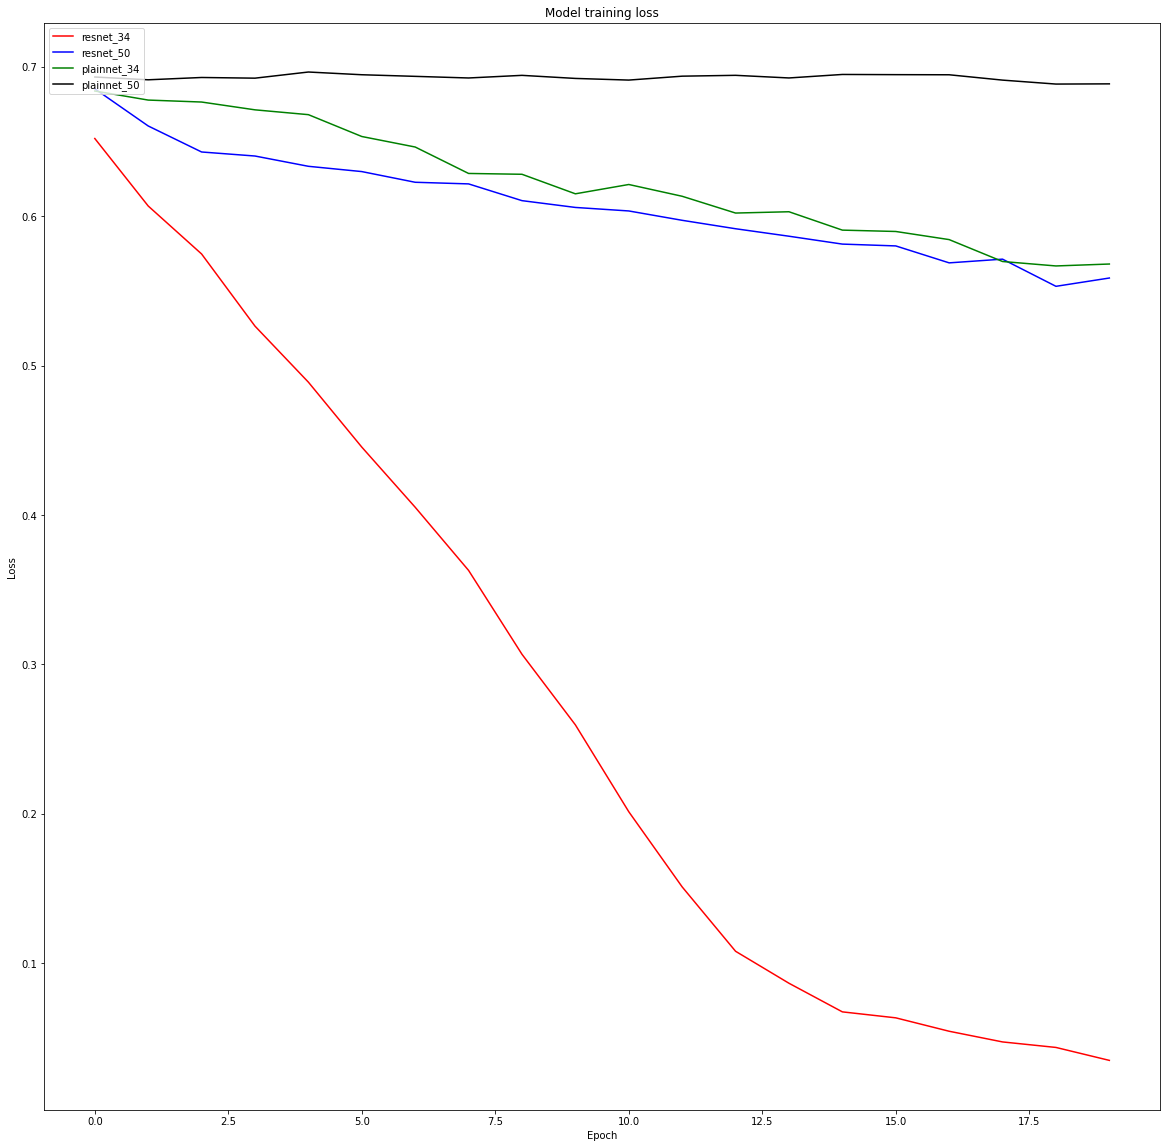

In [29]:
plt.figure(figsize=(20,20))
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.plot(history_plainnet_34.history['loss'], 'g')
plt.plot(history_plainnet_50.history['loss'], 'k')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plainnet_34', 'plainnet_50'], loc='upper left')
plt.show()

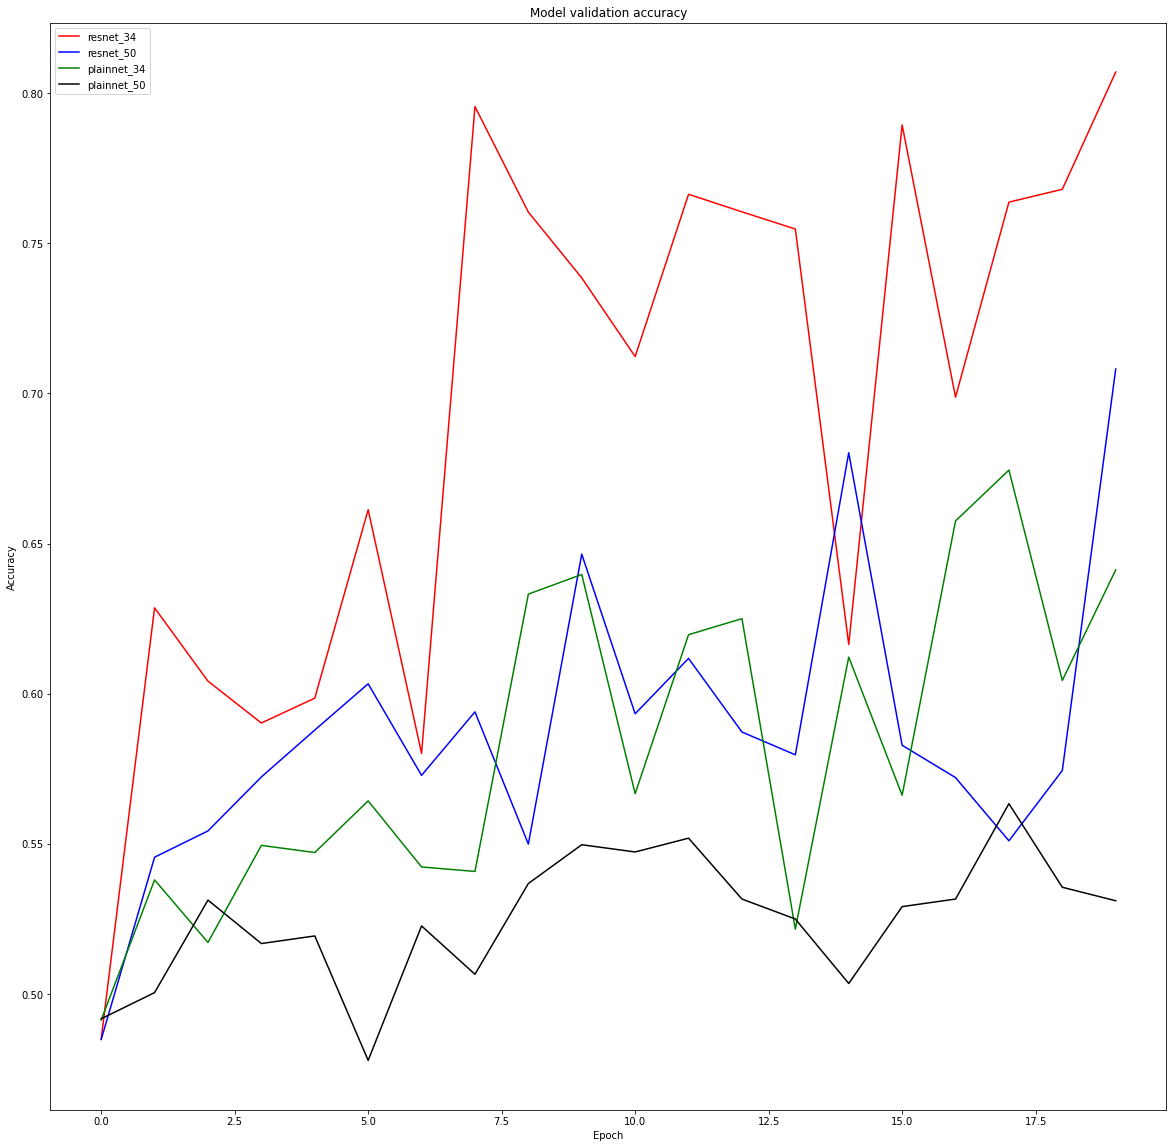

In [30]:
plt.figure(figsize=(20,20))
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.plot(history_plainnet_34.history['val_accuracy'], 'g')
plt.plot(history_plainnet_50.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plainnet_34', 'plainnet_50'], loc='upper left')
plt.show()

In [31]:
loss_res34=[0.7172, 0.6231, 0.5696, 0.5486, 0.5038, 0.4525, 0.4179, 0.3833, 0.3371, 0.3061, 0.2378, 0.1864, 0.1376, 0.108, 0.0834, 0.0699, 0.0577, 0.0509, 0.0448, 0.0414, 0.038, 0.0294, 0.0285, 0.0252, 0.0275, 0.0198, 0.0173, 0.0173, 0.0145, 0.0116, 0.0102, 0.0081, 0.0077, 0.0037, 0.0071, 0.006, 0.0072, 0.0049, 0.0057, 0.0044, 0.0051, 0.0049, 0.0054, 0.0031, 0.0026, 0.0022, 0.0022, 0.0038, 0.0033, 0.0017]
valacc_res34=[0.4884, 0.5616, 0.6362, 0.5475, 0.668, 0.584, 0.6119, 0.5892, 0.7938, 0.7816, 0.681, 0.7474, 0.7533, 0.8191, 0.752, 0.8065, 0.7953, 0.7804, 0.7819, 0.7049, 0.7977, 0.7982, 0.773, 0.7652, 0.7812, 0.8183, 0.8065, 0.8268, 0.8054, 0.8112, 0.8041, 0.8153, 0.7875, 0.7977, 0.7776, 0.7955, 0.7945, 0.8288, 0.8274, 0.8138, 0.8062, 0.8321, 0.8283, 0.7849, 0.833, 0.8105, 0.8416, 0.8368, 0.8394, 0.7773]
loss_res50=[0.7029, 0.6644, 0.6471, 0.6465, 0.6387, 0.6362, 0.625, 0.609, 0.6147, 0.6124, 0.607, 0.61, 0.6074, 0.596, 0.5909, 0.5884, 0.5849, 0.5717, 0.5584, 0.5637, 0.5509, 0.5305, 0.5399, 0.5258, 0.515, 0.4979, 0.5038, 0.4934, 0.4733, 0.4741, 0.4567, 0.4515, 0.4318, 0.4229, 0.4105, 0.3997, 0.3804, 0.3553, 0.3359, 0.3189, 0.2878, 0.2752, 0.2393, 0.2203, 0.1909, 0.1615, 0.1384, 0.1398, 0.1273, 0.1027]
valacc_res50=[0.4926, 0.569, 0.5222, 0.5714, 0.5588, 0.5393, 0.5302, 0.5399, 0.6025, 0.619, 0.6042, 0.6089, 0.6046, 0.6176, 0.5935, 0.6228, 0.6796, 0.5278, 0.6372, 0.576, 0.6218, 0.5621, 0.7025, 0.7147, 0.7199, 0.6868, 0.6343, 0.7161, 0.7465, 0.7064, 0.5933, 0.709, 0.6864, 0.7282, 0.7298, 0.7248, 0.7376, 0.7548, 0.6428, 0.7585, 0.7807, 0.7044, 0.7648, 0.7877, 0.7753, 0.7212, 0.7546, 0.7982, 0.7886, 0.7404]
loss_plain34=[0.6921, 0.6889, 0.6854, 0.6829, 0.6814, 0.6674, 0.6499, 0.6367, 0.6354, 0.6168, 0.6092, 0.608, 0.597, 0.5965, 0.579, 0.5794, 0.5688, 0.5525, 0.5561, 0.527, 0.5115, 0.5123, 0.5033, 0.5002, 0.4852, 0.4599, 0.4568, 0.4407, 0.429, 0.4133, 0.4145, 0.3903, 0.378, 0.3589, 0.3285, 0.3223, 0.3077, 0.2895, 0.2677, 0.2443, 0.2377, 0.2094, 0.1989, 0.1602, 0.1626, 0.1331, 0.1334, 0.1132, 0.0949, 0.0964]
valacc_plain34=[0.5002, 0.5051, 0.5017, 0.5254, 0.4839, 0.6171, 0.5167, 0.6127, 0.5972, 0.6233, 0.6038, 0.5838, 0.6595, 0.6463, 0.6515, 0.6732, 0.6951, 0.5458, 0.694, 0.6719, 0.6717, 0.6968, 0.6088, 0.6417, 0.5673, 0.6602, 0.7335, 0.7038, 0.7576, 0.7099, 0.7796, 0.7644, 0.5983, 0.6977, 0.7739, 0.6489, 0.7598, 0.7391, 0.758, 0.803, 0.6299, 0.8093, 0.7933, 0.8102, 0.7892, 0.7005, 0.7857, 0.8008, 0.6556, 0.7694]
loss_plain50=[0.6926, 0.6913, 0.6879, 0.6888, 0.6921, 0.6911, 0.6906, 0.6862, 0.6878, 0.6874, 0.6923, 0.688, 0.6897, 0.6847, 0.6831, 0.6858, 0.6808, 0.6762, 0.6748, 0.6723, 0.6691, 0.6721, 0.6671, 0.6747, 0.6682, 0.6681, 0.6618, 0.6642, 0.6645, 0.654, 0.6572, 0.6586, 0.6585, 0.6524, 0.65, 0.6379, 0.6402, 0.635, 0.629, 0.6262, 0.6343, 0.6301, 0.6248, 0.6227, 0.6243, 0.6195, 0.6123, 0.6168, 0.6115, 0.6093]
valacc_plain50=[0.4996, 0.49, 0.5343, 0.4808, 0.5588, 0.4807, 0.5289, 0.5336, 0.5113, 0.5482, 0.5499, 0.5447, 0.5493, 0.5386, 0.5454, 0.5516, 0.565, 0.5636, 0.5703, 0.5397, 0.5778, 0.5751, 0.5605, 0.5731, 0.5826, 0.5924, 0.6013, 0.5926, 0.5853, 0.58, 0.6076, 0.5641, 0.5868, 0.6213, 0.5987, 0.6046, 0.5519, 0.5702, 0.6061, 0.523, 0.6178, 0.6228, 0.6165, 0.6508, 0.5799, 0.5701, 0.6331, 0.5981, 0.6469, 0.6053]

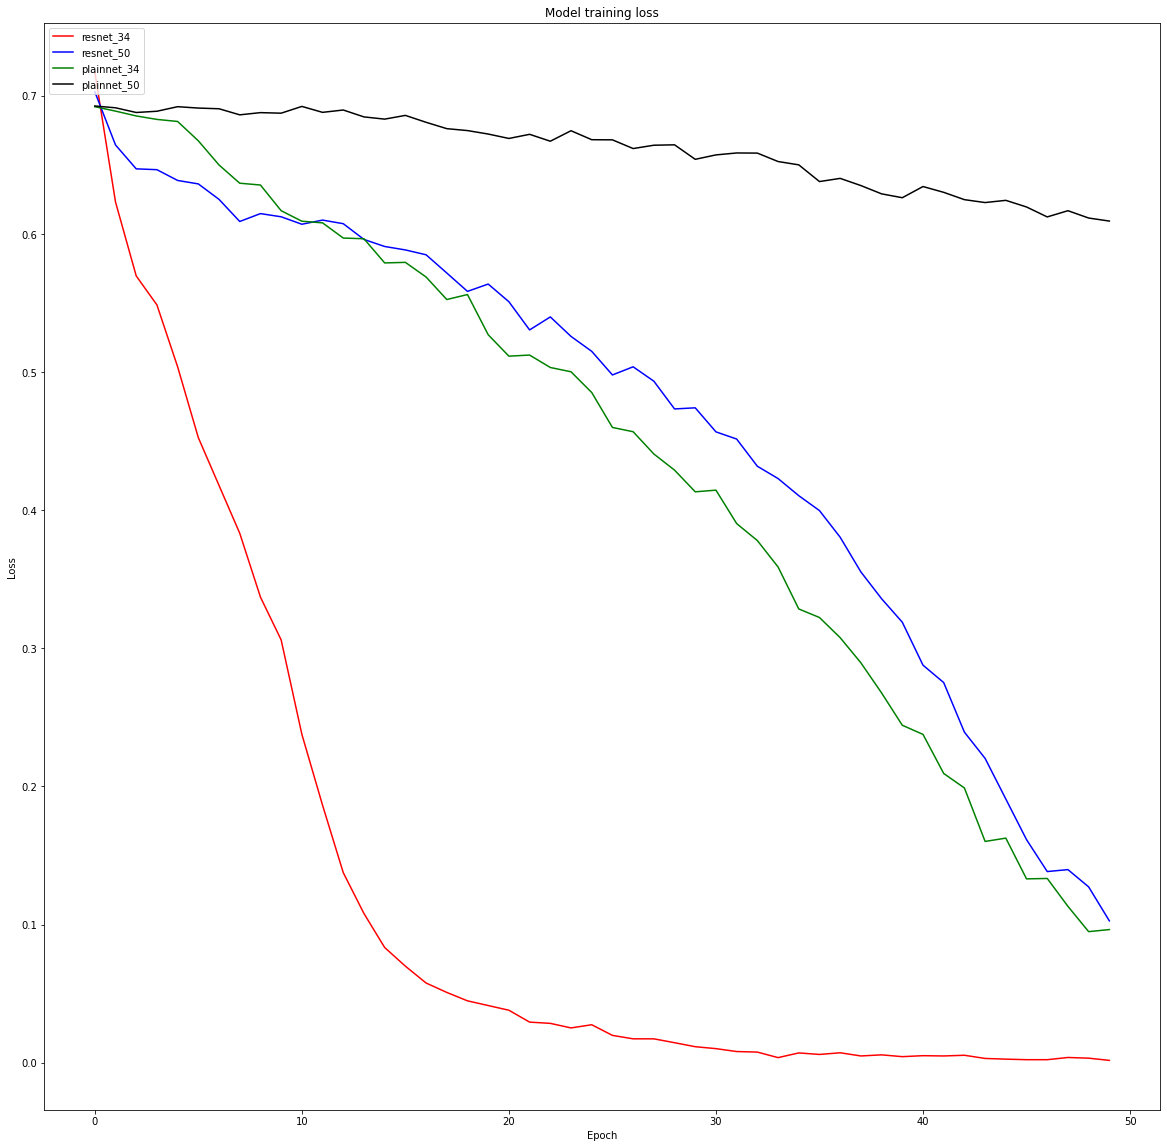

In [32]:
plt.figure(figsize=(20,20))
plt.plot(loss_res34, 'r')
plt.plot(loss_res50, 'b')
plt.plot(loss_plain34, 'g')
plt.plot(loss_plain50, 'k')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plainnet_34', 'plainnet_50'], loc='upper left')
plt.show()

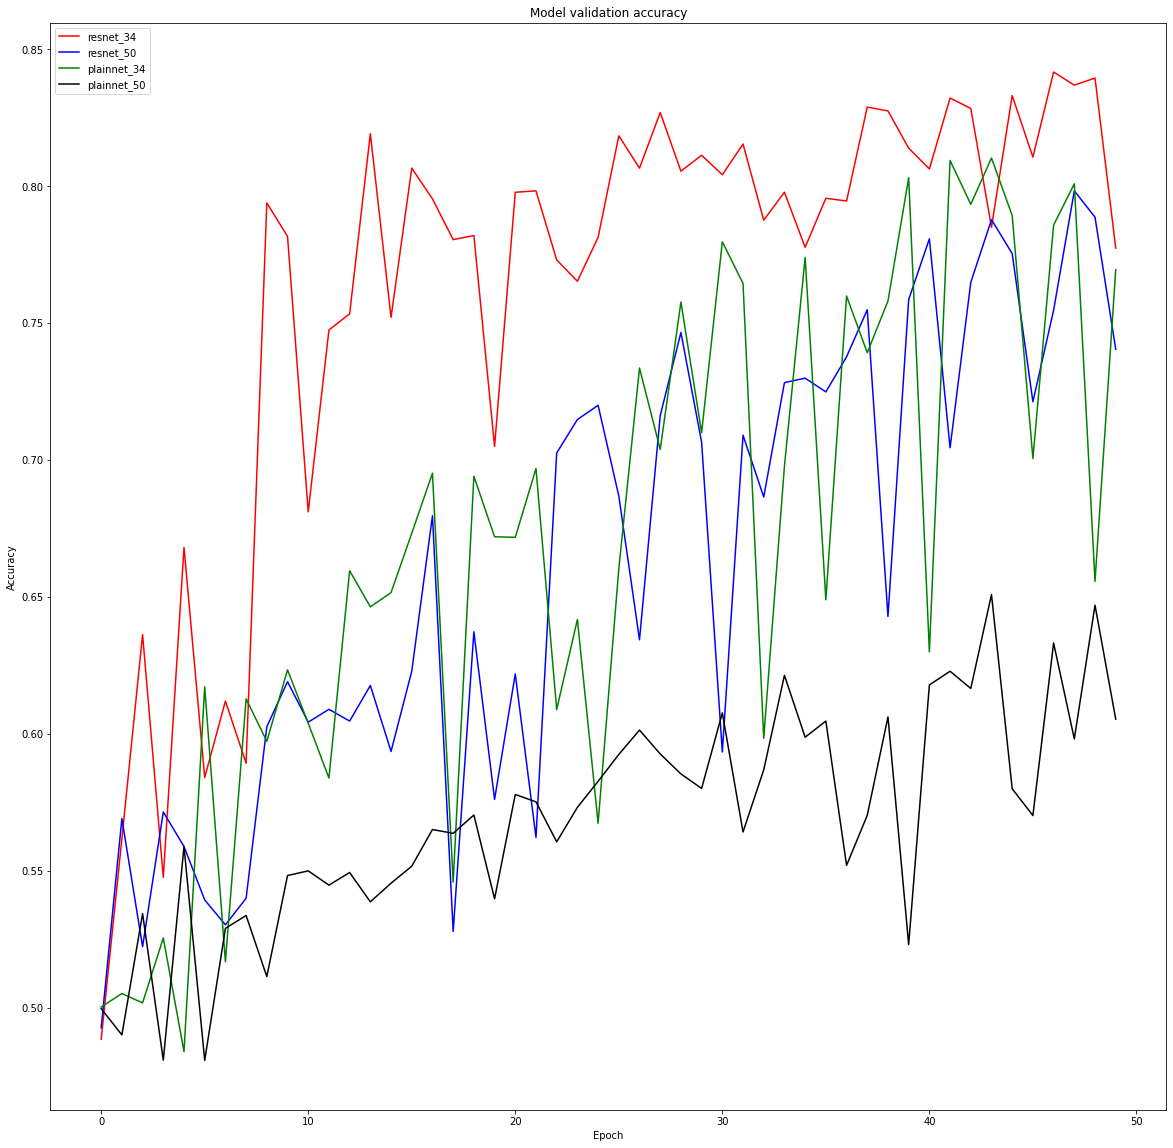

In [33]:
plt.figure(figsize=(20,20))
plt.plot(valacc_res34, 'r')
plt.plot(valacc_res50, 'b')
plt.plot(valacc_plain34, 'g')
plt.plot(valacc_plain50, 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plainnet_34', 'plainnet_50'], loc='upper left')
plt.show()

20 epoch 수행 결과 resnet34 > resnet50 = plainnet34 > plainnet50 으로 loss 감소와 정확도가 나타났다.
50 epoch 수행 결과 20 epoch 수행했을 때와 결과 동일
50 epoch 까지의 수행 결과 같은 층을 이용한 모델끼리 비교해 보면 resnet34 > plainnet34, resnet50 > plainnet50 로 residual shortcut 사용이 모델 성능 향상에 도움된다.
결과 그래프를 보았을 때 resnet34 모델을 제외한 세 모델은 50 epoch로는 학습이 충분하지 못하다.